In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ROOT import TVector3, TLorentzVector
import math, os
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from helpers import addCorrM, addVars, prepPlot, addProb, scanPoint, FoM

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LocallyConnected1D
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.models import load_model

def addProb_temp(df, cl, sc, sk):
    if sk:
        df['prob']= df.apply(lambda x: float(cl.predict_proba(sc.transform(x.values.reshape(1, -1)))[0][1]), axis=1)
    else:
        df['prob']= df.apply(lambda x: \
                             float(cl.predict_proba(np.expand_dims(sc.transform(x.values.reshape(1, -1)),axis=2))[0])
                                   , axis=1)
    return df

cuts={}
cuts['DD']=0.8
cuts['LL']=0.90
cuts['None']=0.7

retrain = False
sklearn = False
apply=False
trainFrac = 0.75
topo = 'None'
loc_class = 'classifier_%s' % topo
loc_scale = 'scaler_%s' % topo

Using TensorFlow backend.


In [2]:
# Load training data
load_folder = '/Users/sbenson/Documents/STBC-Drive/sbenson/BsGammaGamma/offline_training_keras/'
bkg = 'Data_%s_16_9.h5' % topo
sig = 'Data_%s_16_MC.h5' % topo

df_sig = pd.read_hdf(load_folder+sig)
intCut = int(trainFrac * float(len(df_sig)))

df_bkg = pd.read_hdf(load_folder+bkg, start = 0, stop = intCut)
df_sig = pd.read_hdf(load_folder+sig, start = 0, stop = intCut)
print(len(df_sig))
varsCaloChosen = ['calog_ShowerShape', 'calog_LOKI_CaloNeutralE49'
         , 'calog_LOKI_CaloNeutralPrsM', 'calog_LOKI_CaloNeutralSpd'
         , 'calog_LOKI_IsPhoton']
varsCaloChosen = [v.replace('calog','photon') for v in varsCaloChosen]
varsConvChosen = [
    'photon_conv_PT', 'photon_conv_MMERR'
    , 'photon_conv_LOKI_ENDVERTEX_CHI2DOF', 'pos_LOKI_CaloEcalE', 'ele_LOKI_CaloEcalE'
]
varsConvLLChosen = ['photon_conv_LOKI_BPVIP']

6165


In [3]:
# Prepare training data
# Use data already loaded for training
# Rest for testing
if topo =='LL':
    vars_for_training = varsCaloChosen + varsConvChosen + varsConvLLChosen
elif topo == 'DD':
    vars_for_training = varsCaloChosen + varsConvChosen
else:
    vars_for_training = [v.replace('photon','photon1') for v in varsCaloChosen]
    vars_for_training += [v.replace('photon','photon2') for v in varsCaloChosen]
    
df_sig_train = df_sig.loc[:,vars_for_training]
df_bkg_train = df_bkg.loc[:,vars_for_training]
df_sig_train.head()
df_bkg_train.head()

# Create the scaler to preprocess the data
if retrain:
    df_sig_train.reindex(np.random.permutation(df_sig_train.index))
    df_bkg_train.reindex(np.random.permutation(df_bkg_train.index))
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(df_sig_train)
else:
    scaler = joblib.load(load_folder+loc_scale)

sc_sig_train = scaler.transform(df_sig_train)
sc_bkg_train = scaler.transform(df_bkg_train)

In [4]:
# Get test sample
df_sig_test = pd.read_hdf(load_folder+sig, start = intCut)
df_bkg_test = pd.read_hdf(load_folder+bkg, start = intCut, stop = intCut+len(df_sig_test))

print(len(df_sig_test))
print(len(df_bkg_test))

df_sig_test = df_sig_test.loc[:,vars_for_training]
df_sig_test.reindex(np.random.permutation(df_sig_test.index))
df_bkg_test = df_bkg_test.loc[:,vars_for_training]
df_bkg_test.reindex(np.random.permutation(df_bkg_test.index))

sc_sig_test = scaler.transform(df_sig_test)
sc_bkg_test = scaler.transform(df_bkg_test)

2056
2056


In [5]:
# If we use keras, set up the model
def createKeras(inL):
    model = Sequential()
    #model.add(Conv1D (15, 2, input_shape=(inL,1), activation='relu'))
    model.add(LocallyConnected1D (filters=20, kernel_size=2, input_shape=(inL,1), activation='sigmoid'))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())
    # We add a vanilla hidden layer:
    model.add(Dense(15))
    #model.add(Dropout(0.05))
    model.add(Activation('sigmoid'))
    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [6]:
train = np.append(sc_sig_train, sc_bkg_train, axis=0)
target = [1] * len(sc_sig_train) + [-1] * len(sc_bkg_train) 
#
test = np.append(sc_sig_test, sc_bkg_test, axis=0)
target_test = [1] * len(sc_sig_test) + [-1] * len(sc_bkg_test) 
if retrain:
    if sklearn:
        classifier = MLPClassifier(activation='logistic', alpha=2e-05
                               , batch_size='auto', beta_1=0.9, beta_2=0.999
                               , early_stopping=False, epsilon=1e-08
                               , hidden_layer_sizes=(5, 5, 5), learning_rate='constant'
                               , learning_rate_init=0.001, max_iter=200, momentum=0.9
                               , nesterovs_momentum=True, power_t=0.5, random_state=1 
                               , shuffle=False, solver='lbfgs', tol=0.0001, validation_fraction=0.1
                               , verbose=False, warm_start=False) 
        classifier.fit(train, target)
    else:
        train = np.expand_dims(train, axis=2)
        test = np.expand_dims(test, axis=2)
        classifier = createKeras(len(vars_for_training))
        classifier.fit(train, target,
          batch_size=1,
          epochs=50, validation_data=(test, target_test))
else:
    if sklearn:
        classifier = joblib.load(load_folder+loc_class)
    else:
        classifier = load_model(load_folder+loc_class+'.h5')

In [7]:
# Find predicted probs. for training and test samples
df_sig_train2 = addProb_temp(df_sig_train, classifier, scaler, sklearn)
df_sig_test2 = addProb_temp(df_sig_test, classifier, scaler, sklearn)
df_bkg_train2 = addProb_temp(df_bkg_train, classifier, scaler, sklearn)
df_bkg_test2 = addProb_temp(df_bkg_test, classifier, scaler, sklearn)

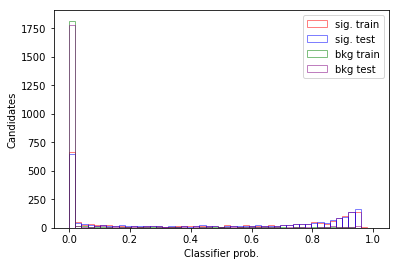

In [8]:
# Plot comparison of the distributions
bins_pr = np.linspace(0, 1, 50)
fig, ax1 = plt.subplots()
colors = ['red', 'tan', 'lime', 'blue']
h_sig_train = df_sig_train.sample(n=len(df_sig_test)).hist(column=['prob'], ax=ax1, fill=False, edgecolor = 'red', bins = bins_pr, alpha=0.5, label="sig. train")
h_sig_test = df_sig_test.hist(column=['prob'], ax=ax1, fill=False, edgecolor = 'blue', bins = bins_pr, alpha=0.5, label="sig. test")
h_bkg_train = df_bkg_train.sample(n=len(df_sig_test)).hist(column=['prob'], edgecolor = 'green', ax=ax1, fill=False, bins = bins_pr, alpha=0.5, label="bkg train")
h_bkg_test = df_bkg_test.hist(column=['prob'], ax=ax1, fill=False, edgecolor = 'purple', bins = bins_pr, alpha=0.5, label="bkg test")
prepPlot(ax1, "Classifier prob.", "Candidates")
plt.legend()
plt.savefig("classifier_%s.pdf" % topo)
plt.show()

In [9]:
if retrain:
    # Update the persisted files
    if sklearn:
        joblib.dump(classifier, loc_class)
    else:
        classifier.save(loc_class.rstrip('.pkl')+'.h5')
    joblib.dump(scaler, loc_scale)

/Users/sbenson/anaconda3/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


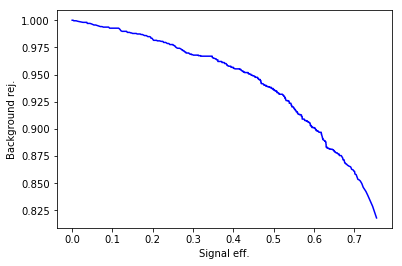

Cut point for topo None: 0.7
Sig eff: 0.40, BKG rej: 0.96


In [10]:
# Plot ROC comparison & FoM optimisation
eff_sig_train = []
eff_sig_test = []
rej_bkg_train = []
rej_bkg_test = []
#
FoMScore = []
scanpoints = np.linspace(0.0, 0.001, 1000)
scanpoints += np.linspace(0.001, 1.0, 1000)
for s in scanpoints:
    es, rb, nSig, nBKG = scanPoint(s, df_sig_test, df_bkg_test)
    es_tr, rb_tr, nSig_tr, nBKG_tr = scanPoint(s, df_sig_train, df_bkg_train)
    eff_sig_test.append(es)
    rej_bkg_test.append(rb)
    eff_sig_train.append(es_tr)
    rej_bkg_train.append(rb_tr)
    FoMScore.append(FoM(nSig, nBKG))

fig, axes = plt.subplots()#1, 2, figsize=(30, 10))
plt1, = axes.plot(eff_sig_test, rej_bkg_test, 'b-')#, label = 'test')
#plt2, = axes[0].plot(eff_sig_train, rej_bkg_train, 'b-', label= 'train')
plt.legend()#handles=[plt1,plt2])
prepPlot(axes, "Signal eff.", "Background rej.")
plt.savefig("roc_%s.pdf" % topo)
#axes[1].plot(scanpoints, FoMScore, 'r-')
#prepPlot(axes[1], "Cut value", "FoM value")
plt.show()

# Numbers for our chosen working point
es, rb, nSig, nBKG = scanPoint(cuts[topo], df_sig_train, df_bkg_train)
print ("Cut point for topo %s: %s" % (topo,cuts[topo]))
print ("Sig eff: %.2f, BKG rej: %.2f" % (es,rb))

In [11]:
# Apply classifier to signal region
if apply:
    output = 'combined_%s.h5' % topo
    for n, file in enumerate(os.listdir(load_folder+'localData')):
        if topo not in file:
            continue
        print ('Loading file: %s' %(file))
        try:
            df_dsig = pd.read_hdf(load_folder+'localData/'+file)
        except:
            continue
        df_dsig_red = df_dsig.loc[:,vars_for_training]
        df_dsig_red = addProb_temp(df_dsig_red, classifier, scaler, sklearn)

        len_bf = len(df_dsig)
        # Cut on the probability
        df_dsig = df_dsig[df_dsig_red['prob']>cuts[topo]]
        len_af = len(df_dsig)
        print('Passed %s/%s candidates, frac = %.3f' % (len_af, len_bf, float(len_af)/float(len_bf)))
        # Add to the output file
        df_dsig.to_hdf(load_folder+output, 'df_dsig', append=True)